How does the availability of vegetarian and vegan dishes vary by area?

In [45]:
import os

os.chdir('C:/Users/esram/OneDrive/Desktop/esrabecode/delivery-market-analysis')

os.getcwd()

'C:\\Users\\esram\\OneDrive\\Desktop\\esrabecode\\delivery-market-analysis'

In [46]:
import sqlite3
import pandas as pd
import folium
from folium.plugins import MarkerCluster

conn = sqlite3.connect('data/takeaway.db')

query_city = """
SELECT 
    r.city,
    COUNT(DISTINCT r.primarySlug) AS veg_restaurant_count,
    AVG(m.price) AS avg_veg_price,
    GROUP_CONCAT(DISTINCT r.name) AS restaurants,
    GROUP_CONCAT(DISTINCT m.name) AS veg_items,
    AVG(r.latitude) AS lat,
    AVG(r.longitude) AS lon
FROM restaurants r
JOIN menuItems m
    ON r.primarySlug = m.primarySlug
WHERE LOWER(m.name) LIKE '%veg%'
  AND LOWER(m.name) NOT LIKE '%non%'
GROUP BY r.city
ORDER BY r.city;
"""

df_city = pd.read_sql_query(query_city, conn)
df_city



,city,veg_restaurant_count,avg_veg_price,restaurants,veg_items,lat,lon
0,1040,1,12.000000,Snack Thieffry,Menu bicky burger 100% vegetarien avec pain ar...,50.830792,4.399869
1,Aalst,29,9.401399,"Fistro,Frituur Anita,Frituur Mijlbeek,Pitta Mo...","Vegan goulash,Vegan seitan stew,Vegan groenten...",50.942663,4.039468
2,Aalter,3,9.541667,"Pizza Valo,Pita Pizza Pyramide,Njam Njam Pizza","Pizza vegetarisch (small),Pizza vegetarisch (m...",51.088105,3.447887
3,Aarschot,8,9.675000,"Istanbul Grill Huis,Efes bij Carlos Niko,De Ec...","Vegetariana,Spaghetti vegetarisch,Broodje vege...",50.989690,4.834420
4,Aarstelaar,1,14.128571,Mati Sushi,"Veggie combo,Veggie sushi boot (2 pers),Veg re...",51.134349,4.387790
...,...,...,...,...,...,...,...
448,Zulte,2,11.295000,"Pitta Melita,Pizzeria Valsugana","Schotel vegetarisch met geitenkaas,Schotel veg...",50.922614,3.445693
449,Zutendaal,1,10.375000,Grillhouse Kusadasi,"Pizza vegetariana,Pizza vegetale,Vegetarisch b...",50.931139,5.574194
450,Zwevegem,2,14.270000,"Pizza Taliano,Big Bites","Pizza Vegetariana,Pasta penne vegetariana,Vegg...",50.815638,3.324394
451,Zwijnaarde,1,11.950000,Top Pizza,"Pizza vegetarisch,Pasta veg. met tomatensaus",51.002608,3.714564


In [47]:
df_city.columns


Index(['city', 'veg_restaurant_count', 'avg_veg_price', 'restaurants',
       'veg_items', 'lat', 'lon'],
      dtype='object')

In [48]:
import folium
from branca.colormap import linear

# df_city hazır, sütunlar: city, veg_restaurant_count, avg_veg_price, restaurants, veg_items, lat, lon

# Harita oluştur
m = folium.Map(
    location=[df_city.lat.mean(), df_city.lon.mean()],
    zoom_start=6,
    tiles="cartodbpositron"
)

# Renk skalası (yeşil tonları, yoğunluk)
colormap = linear.YlGn_09.scale(
    df_city.veg_restaurant_count.min(),
    df_city.veg_restaurant_count.max()
)
colormap.caption = "Veg Restaurant Density by City"
colormap.add_to(m)

# Şehirleri ekle
for _, row in df_city.iterrows():
    folium.CircleMarker(
        location=[row.lat, row.lon],
        radius=6 + row.veg_restaurant_count * 0.2,  # yoğunluk arttıkça balon büyür
        color=colormap(row.veg_restaurant_count),
        fill=True,
        fill_color=colormap(row.veg_restaurant_count),
        fill_opacity=0.7,
        popup=folium.Popup(f"""
            <b>{row.city}</b><br>
            Veg Restaurants: {row.veg_restaurant_count}<br>
            Avg Price: {row.avg_veg_price:.2f}<br>
            <b>Restaurants:</b> {row.restaurants}<br>
            <b>Veg Items:</b> {row.veg_items}
        """, max_width=400)
    ).add_to(m)

# Haritayı göster
m.save("veg_restaurant_map.html")


Top 20 cities with the highest veg restaurant density using a horizontal bar chart:

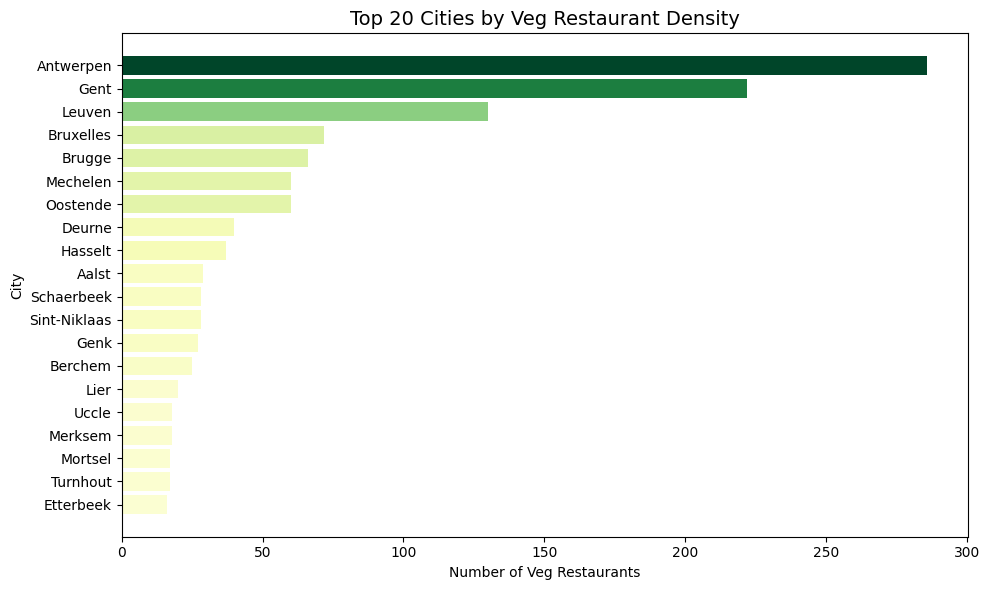

In [57]:
import matplotlib.pyplot as plt

# Take top 20 cities by veg restaurant count
top_cities = df_city.sort_values('veg_restaurant_count', ascending=False).head(20)

plt.figure(figsize=(10,6))

# Normalize veg restaurant counts to 0-1 for color mapping
norm = top_cities['veg_restaurant_count'] / top_cities['veg_restaurant_count'].max()
colors = plt.cm.YlGn(norm)  # Yellow (low) -> Green (high)

# Horizontal bar chart
plt.barh(
    top_cities['city'][::-1],  # reverse for descending order
    top_cities['veg_restaurant_count'][::-1],
    color=colors[::-1]  # reverse colors to match bar order
)

plt.xlabel("Number of Veg Restaurants")
plt.ylabel("City")
plt.title("Top 20 Cities by Veg Restaurant Density", fontsize=14)
plt.tight_layout()
plt.show()
